## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I computed the camera calibration using chessboard images

I looped over the 20 calibration images provided with the project. On each image, I tried different grid size options starting with the largest grid until cv2.findChessboardCorners() was able to accurately detect internal chessboard corners on the image. I maintained two lists - first, a list of object points which contains the indices of the chessboard corners, and second, a list of image points containing the actual pixel location of the detected corner in the calibration image.


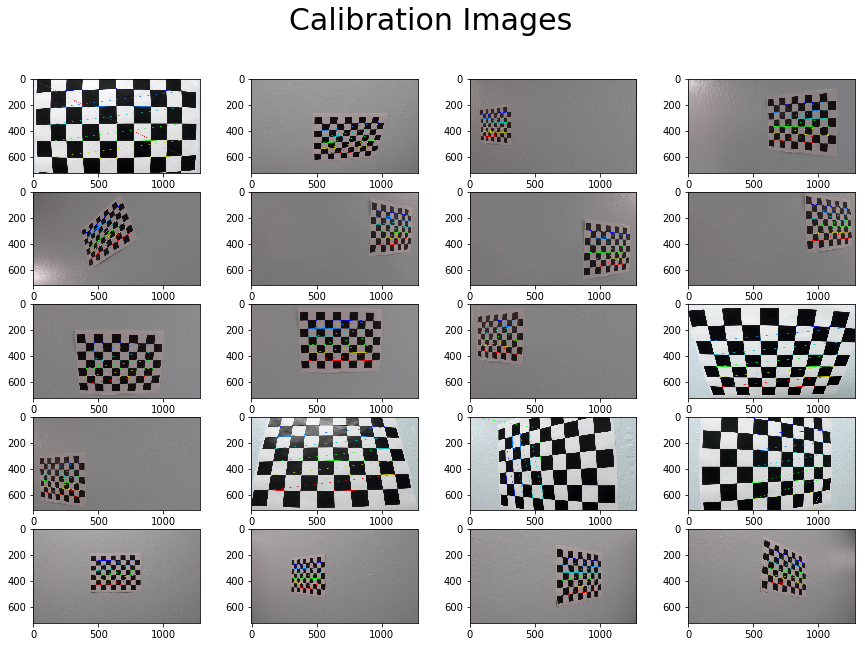

In [2]:
# Import required libraries
import numpy as np
import math
import cv2
import glob
import random
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline
    
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
f, axarr = plt.subplots(math.ceil(len(images)/4), 4, figsize=(15,10))
plt.suptitle('Calibration Images', fontsize=30)

# Search for grids of the following sizes starting with
# the biggest, and successively shrinking it until
# CV2's findChessboardCorners() method detects corners
# successfully
grid_size_options = [[9,6],[9,5],[7,6],[6,5]]

# Step through the list and search for chessboard corners
count = 0
for fname in images:
    img = cv2.imread(fname)
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret = False
    options_index = 0
    # Loop through all size options until we find one
    # where we are able to succesfully detect chessboard
    # corners
    while ((ret == False) and (options_index < len(grid_size_options))):
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, \
                                                 (grid_size_options[options_index][0], \
                                                  grid_size_options[options_index][1]),\
                                                  None)
        options_index += 1

    # If found, add object points, image points
    if ret == True:
        options_index -= 1
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((grid_size_options[options_index][1]*grid_size_options[options_index][0],3), np.float32)
        objp[:,:2] = np.mgrid[0:grid_size_options[options_index][0],0:grid_size_options[options_index][1]].T.reshape(-1,2)        
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners as a sanity check
        img = cv2.drawChessboardCorners(cv2.imread(fname), (9,6), corners, ret)
        axarr[math.floor(count/4), count % 4].imshow(img)
        
    count = count + 1

plt.savefig('Calibration.png')
plt.show()
plt.close(f)    # close the figure

## Compute and apply distortion correction

I then applied cv2.calibrateCamera() method to obtain the calibration matrix. I applied the calibration matrix to undistort a sample image. The original image and the undistorted image are plotted below.

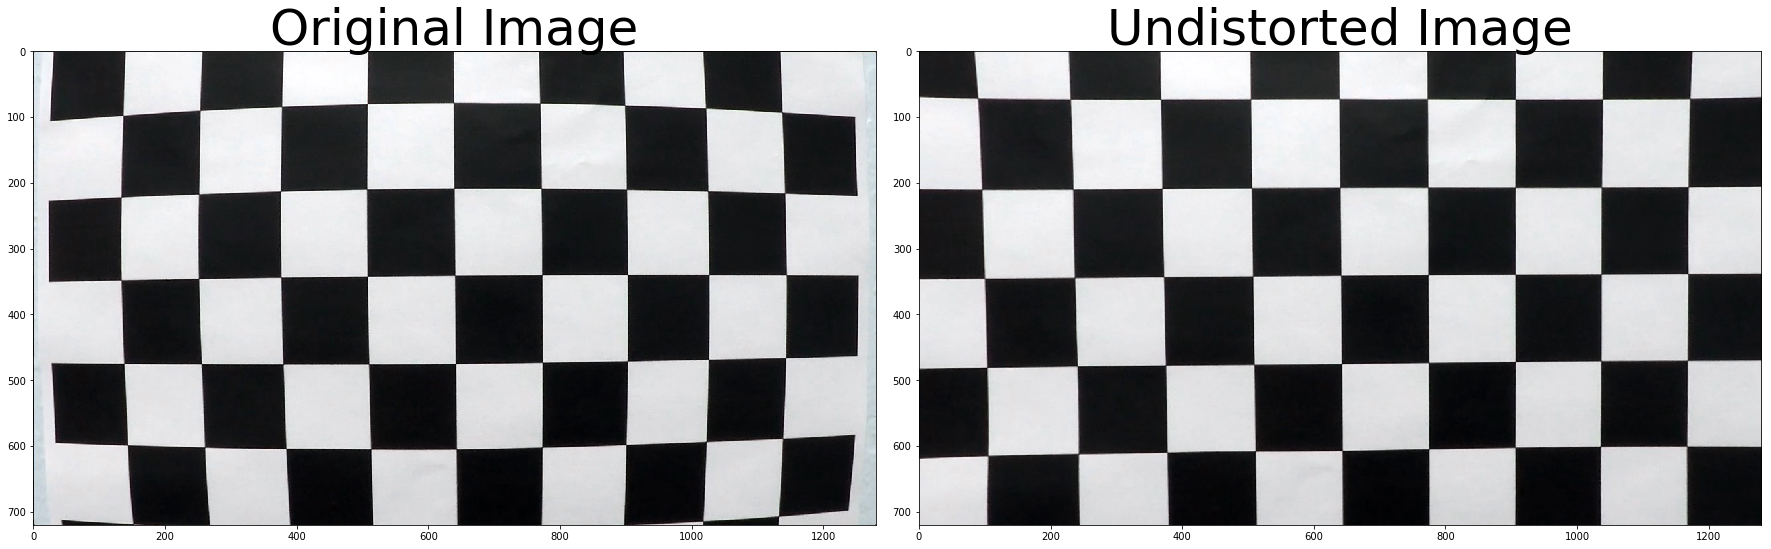

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
img = cv2.imread('camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('Undistort.png')
plt.show()
plt.close(f)    # close the figure

## Create binary thresholded image for a test image

I used the R- and S- components of the image for binary thresholding. I applied a Sobel kernel of size 7 in both x- and y- direction to these components. Next, I used empirically determined thresholds for the absolute values, magnitude and direction of the gradients to create my binary thresholded image.

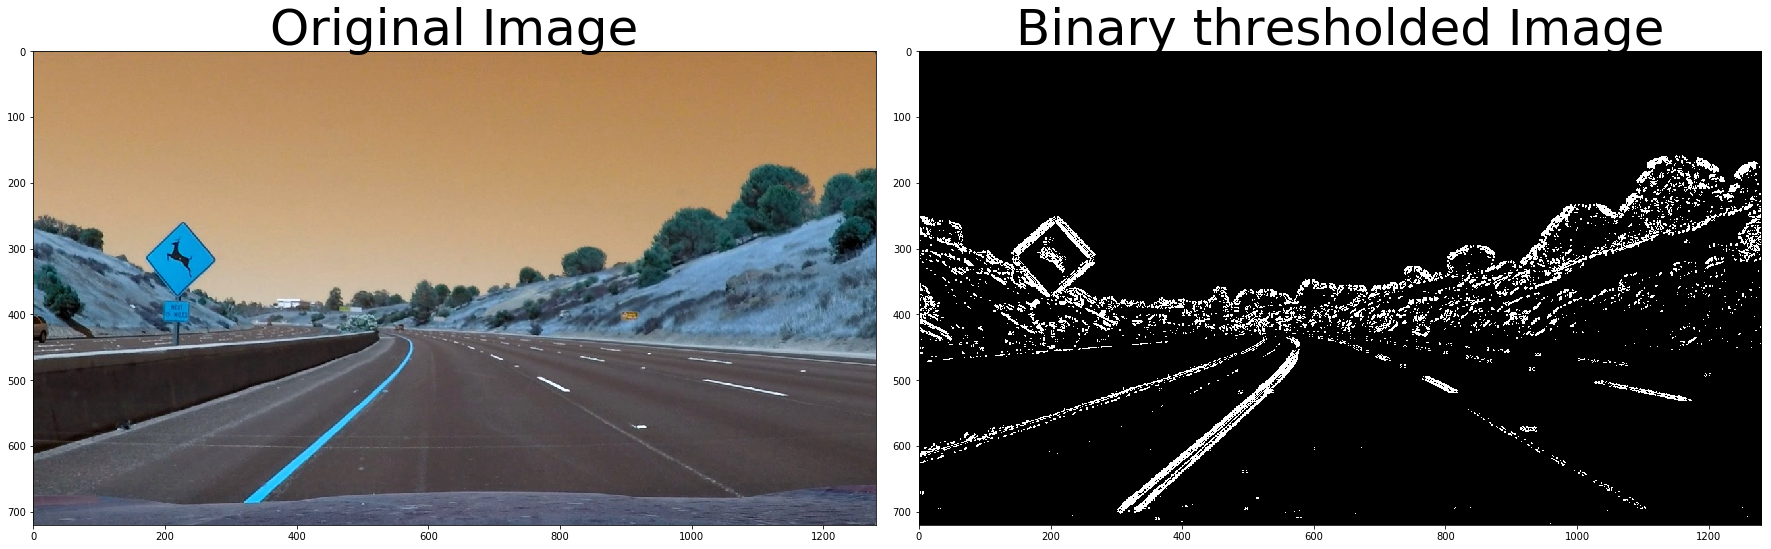

In [4]:
def abs_sobel_thresh(S_sobelx, S_sobely, R_sobelx, R_sobely, orient='x', thresh=(20,100)):
    
    # Select the S - derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = S_sobelx
    elif orient == 'y':
        sobel = S_sobely
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Create a mask of 1's where the scaled gradient magnitude 
    # is >= thresh_min and <= thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Select the R - derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = R_sobelx
    elif orient == 'y':
        sobel = R_sobely
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Create a mask of 1's where the scaled gradient magnitude 
    # is >= thresh_min and <= thresh_max
    sxbinary1 = np.zeros_like(scaled_sobel)
    sxbinary1[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # OR the two masks
    sxbinary = sxbinary | sxbinary1
    
    # Return this mask as your binary_output image
    return sxbinary

# Define a function that computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(S_sobelx, S_sobely, R_sobelx, R_sobely, mag_thresh=(30, 100)):
    
    # Calculate the magnitude of the S-derivative
    sobel_mag = np.sqrt(S_sobelx * S_sobelx + S_sobely * S_sobely)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    # Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # Calculate the magnitude of the R-derivative
    sobel_mag = np.sqrt(R_sobelx * R_sobelx + R_sobely * R_sobely)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    # Create a binary mask where mag thresholds are met
    sxbinary1 = np.zeros_like(scaled_sobel)
    sxbinary1[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    # OR the two masks
    sxbinary = sxbinary | sxbinary1

    # Return this mask as your binary_output image
    return sxbinary

def dir_threshold(S_sobelx, S_sobely, R_sobelx, R_sobely, thresh=(0.7, 1.3)):
    
    # Take the absolute value of the x and y S-gradients
    abs_sobelx = np.absolute(S_sobelx)
    abs_sobely = np.absolute(S_sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arctan_sobel = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(arctan_sobel)
    sxbinary[(arctan_sobel >= thresh[0]) & (arctan_sobel <= thresh[1])] = 1

    # Take the absolute value of the x and y R-gradients
    abs_sobelx = np.absolute(R_sobelx)
    abs_sobely = np.absolute(R_sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arctan_sobel = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    sxbinary1 = np.zeros_like(arctan_sobel)
    sxbinary1[(arctan_sobel >= thresh[0]) & (arctan_sobel <= thresh[1])]

    # OR the two masks
    sxbinary = np.uint8(sxbinary) | np.uint8(sxbinary1)
    
    # Return this mask as your binary_output image
    return sxbinary

def binary_threshold(img, sobel_kernel_size = 7, sx_thresh=(170, 255)):

    # Compute the gradients for R and S components in x- and y- directions
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    R = img[:,:,0]
    S_sobelx = cv2.Sobel(S, cv2.CV_64F, 1, 0, ksize = sobel_kernel_size)
    S_sobely = cv2.Sobel(S, cv2.CV_64F, 0, 1, ksize = sobel_kernel_size)
    R_sobelx = cv2.Sobel(R, cv2.CV_64F, 1, 0, ksize = sobel_kernel_size)
    R_sobely = cv2.Sobel(R, cv2.CV_64F, 0, 1, ksize = sobel_kernel_size)
    
    # Get binary threshold masks for gradient, magnitude and direction of R- and S- components
    gradx = abs_sobel_thresh(S_sobelx, S_sobely, R_sobelx, R_sobely, orient='x', thresh=sx_thresh)
    grady = abs_sobel_thresh(S_sobelx, S_sobely, R_sobelx, R_sobely, orient='y', thresh=sx_thresh)
    mag_binary = mag_thresh(S_sobelx, S_sobely, R_sobelx, R_sobely, mag_thresh=(170, 255))
    dir_binary = dir_threshold(S_sobelx, S_sobely, R_sobelx, R_sobely, thresh=(0.7, 1.6))

    # Combine the masks
    combined = np.zeros_like(gradx)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined = np.uint8(255*combined)
    
    # Stack combined mask into 3-channel image   
    binary = np.dstack(( combined, combined, combined))
    
    # Return mask image
    return binary

img = cv2.imread('test_images/test2.jpg')
undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
binary_img = binary_threshold(undistorted_img, sobel_kernel_size = 7, sx_thresh=(20, 100))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_img)
ax2.set_title('Binary thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('Binary_Thresholded_Image.png')
plt.show()
plt.close(f)    # close the figure


## Apply birds eye view perspective transform

I visually examined the binary thresholded image to obtain a reasonable warping transformation. The boundaries for the quadilateral in the original and warped images are shown in the figures below.

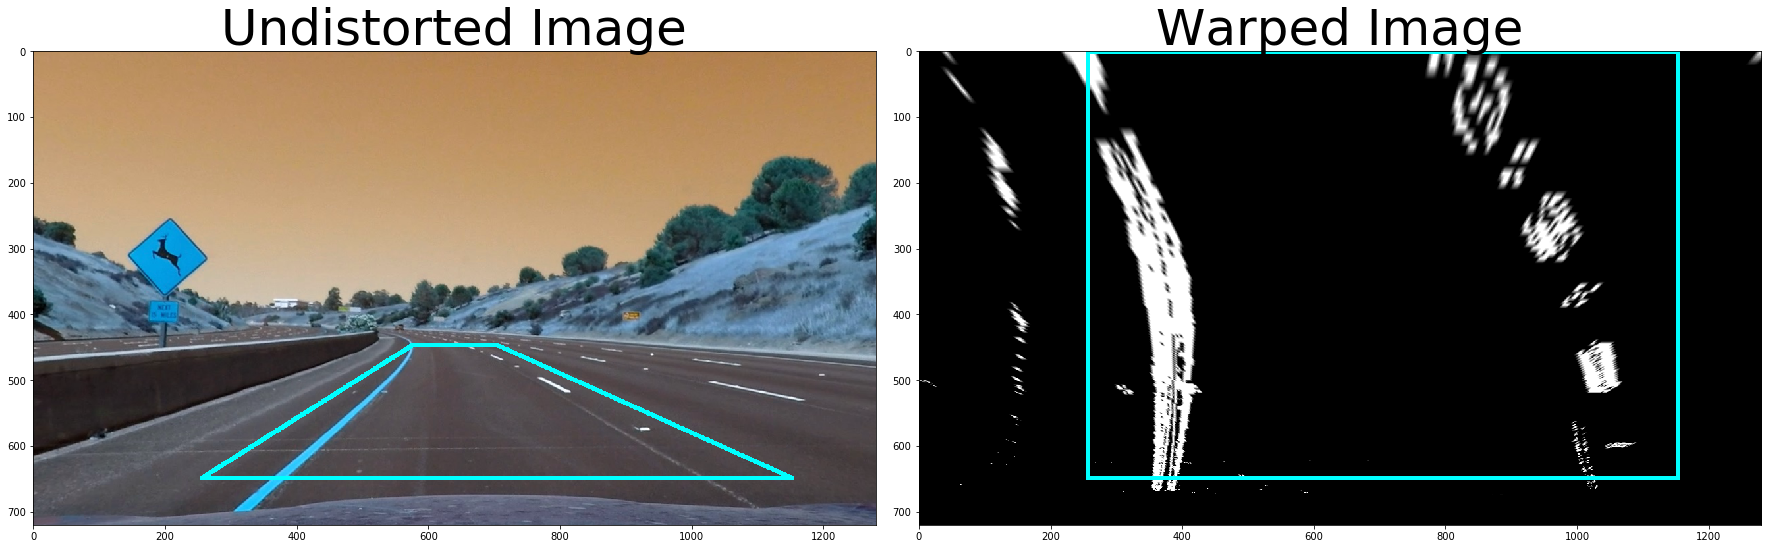

In [5]:
def birdseye_transform(img):
    global M # Matrix which stores the warping transform
    global original_coordinates, warped_coordinates
    
    ysize = img.shape[0]
    xsize = img.shape[1]

    #Harcode region of interest by visual inspection
    original_coordinates = np.float32([[np.round(xsize*0.20),ysize*0.9],\
                                       [np.round(xsize*0.45),np.round(ysize*0.62)],\
                                       [np.round(xsize*0.55),np.round(ysize*0.62)],\
                                       [np.round(xsize*0.90),ysize*0.9]])

    warped_coordinates = np.float32([[np.round(xsize*0.2),np.round(ysize*0.9)],\
                                     [np.round(xsize*0.2),np.round(ysize*0.0)],\
                                     [np.round(xsize*0.9),np.round(ysize*0.0)],\
                                     [np.round(xsize*0.9),np.round(ysize*0.9)]])

    #if (len(M) == 0):
    M = cv2.getPerspectiveTransform(original_coordinates, warped_coordinates)
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR) 
    return warped

img = cv2.imread('test_images/test2.jpg')
undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
binary_img = binary_threshold(undistorted_img, sobel_kernel_size = 7, sx_thresh=(20, 100))
warped_img = birdseye_transform(binary_img)
ysize = img.shape[0]
xsize = img.shape[1]
pts = np.array(original_coordinates, np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(undistorted_img,[pts],True,(0,255,255),6)
pts = np.array(warped_coordinates, np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(warped_img,[pts],True,(0,255,255),6)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_img)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(warped_img)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('Binary_Thresholded_Image.png')
plt.show()
plt.close(f)    # close the figure

# Apply sliding window

I applied the sliding window technique as presented in the course. I added the following modifications to improve the robustness and speed of detection.

I restricted the search for the sliding window position based on the window position located in the previous frame, as well the window position of the immediate neightbour window. I also discard window positions which lead to inconsistent curvature and offset values from previous frames as well as with respect to the opposing lane-line. In such cases, the lane line estimate is kept unchanged from it's previous value. If the lane line was not detected with confidence for two consecutive frame, I discard previously recorded lane metrics, and re-search the image to obtain fresh estimates for window positions and lane curves. To speed up window detection, I further restric the margin of window search to +/- 50 pixels in the neighbourhood of a previously detected window which had high confidence. If not neighbouring window was detected, I widen the search margin to +/- 100 pixels. 


In [6]:
def weight_image(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [10]:
def apply_sliding_window(img):

    global left_fit_cr_past, right_fit_cr_past
    global left_fit_past, right_fit_past
    global leftx_past_window_array, rightx_past_window_array
    global left_past_curverad, right_past_curverad
    global lost_frames

    # Create an output image to draw on and  visualize the result
    out_img = np.copy(img[:,:,0])

    # If we have not previously computed a best left/right fit, or did
    # not confidently detect fits for the past 3 frames, re-search
    # the image to find the best fit curve
    if (((len(left_fit_past) == 0) or (len(right_fit_past) == 0)) or \
        (lost_frames > 3)):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(out_img[int(out_img.shape[0]/2):,:], axis=0)
        midpoint = np.int(histogram.shape[0]/2)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        lost_frames = 0 # Reset count of lost frames
    else:
        # We have accurately estimated the best left/right fit curves
        # recently. Use this.
        leftx_base = np.int(left_fit_past[0]*(out_img.shape[0]-1)**2 + left_fit_past[1]*(out_img.shape[0]-1) + left_fit_past[2])
        rightx_base = np.int(right_fit_past[0]*(out_img.shape[0]-1)**2 + right_fit_past[1]*(out_img.shape[0]-1) + right_fit_past[2])

    # Choose the number of sliding windows
    nwindows = 20

    # Set height of windows
    window_height = np.int(out_img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = out_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin_left = 50
    margin_right = 50
    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        if (len(leftx_past_window_array) < window+1):
            leftx_past_window_array.append(0) # Create array to store past window positions for left lane
        if (len(rightx_past_window_array) < window+1):
            rightx_past_window_array.append(out_img.shape[0]) # Create array to store past window positions
                                                              # for right lane

        # Identify window boundaries in x and y (and right and left)
        # with a margin along x direction
        win_y_low = out_img.shape[0] - (window+1)*window_height
        win_y_high = out_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin_left
        win_xleft_high = leftx_current + margin_left
        win_xright_low = rightx_current - margin_right
        win_xright_high = rightx_current + margin_right
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,255,255), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(255,255,255), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            margin_left = 50
            if (leftx_past_window_array[window] > 0):
                # Threshold the current window location to be
                # within 50 pixels of window location in previous
                # frame
                leftx_low_past = leftx_past_window_array[window] - 50
                leftx_high_past = leftx_past_window_array[window] + 50
                leftx_current = max(min(leftx_current, leftx_high_past), leftx_low_past)
                leftx_past_window_array[window] = leftx_current   
            if (leftx_past > 0):
                # Threshold the current window location to be
                # within 50 pixels of neighbouring window location                
                leftx_current = max(leftx_past - 50, leftx_current)
                leftx_current = min(leftx_past + 50, leftx_current)
                leftx_past = leftx_current
        else:
            # We are not confident about location of the window
            # Widen the margin to 100 pixels and clear array for past
            # window positions detected
            leftx_past_window_array[window] = 0
            leftx_past = 0
            margin_left = 100
        
        # Do same steps as lines 81-104 for right lane
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            margin_right = 50
            if (rightx_past_window_array[window] < out_img.shape[0]):
                rightx_low_past = rightx_past_window_array[window] - 50
                rightx_high_past = rightx_past_window_array[window] + 50
                rightx_current = max(min(rightx_current, rightx_high_past), rightx_low_past)
                rightx_past_window_array[window] = rightx_current
            if (rightx_past < out_img.shape[0]):
                rightx_current = max(rightx_past - 50, rightx_current)
                rightx_current = min(rightx_past + 50, rightx_current)
        else:
            rightx_past_window_array[window] = out_img.shape[0]
            rightx_past = out_img.shape[0]
            margin_right = 100
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    if ((len(lefty) > 0) and (len(leftx) > 0)):
        # if valid indices are detected fit a 2nd degree
        # polynomial
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        # Else, use the last fit
        left_fit = left_fit_past

    # Ditto for right lane
    if ((len(righty) > 0) and (len(rightx) > 0)):
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = right_fit_past

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )    
    y_eval = np.max(ploty)
    
    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / (2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / (2*right_fit_cr[0])
    l_eval = np.polyval(left_fit_cr, y_eval*ym_per_pix)
    r_eval = np.polyval(right_fit_cr, y_eval*ym_per_pix)
    lane_center = np.average([l_eval, r_eval])
    image_center = int(out_img.shape[1]/2) * xm_per_pix
    offset = (lane_center - image_center) 
    
    if ((left_past_curverad != 0) and (right_past_curverad != 0)):
        #Validate left and right curvature and offset
        if ((np.sign(left_curverad) == np.sign(right_curverad)) and 
            (np.absolute(offset) < 0.5)):
            left_past_curverad = left_curverad
            left_fit_past = left_fit
            right_past_curverad = right_curverad 
            right_fit_past = right_fit            
        else:
            # If curvature or offset look off
            # use previously computed values
            if (len(left_fit_cr_past) != 0):
                left_fit_cr = left_fit_cr_past            
            if (len(left_fit_past) != 0):
                left_fit = left_fit_past
            if (len(right_fit_cr_past) != 0):
                right_fit_cr = right_fit_cr_past
            if (len(right_fit_past) != 0):
                right_fit = right_fit_past
            left_curverad = left_past_curverad
            right_curverad = right_past_curverad
            lost_frames+=1 #Increment number of lost frames

    curve_rad = np.average(np.absolute([left_curverad, right_curverad]))
    
    # Now our radius of curvature is in meters
    l_eval = np.polyval(left_fit_cr, y_eval*ym_per_pix)
    r_eval = np.polyval(right_fit_cr, y_eval*ym_per_pix)
    lane_center = np.average([l_eval, r_eval])
    image_center = int(out_img.shape[1]/2) * xm_per_pix
    offset = (lane_center - image_center) 

    # Store curvature and best fit curves for next frame
    left_past_curverad = left_curverad
    right_past_curverad = right_curverad
    left_fit_cr_past = left_fit_cr
    right_fit_cr_past = right_fit_cr
    right_fit_past = right_fit
    left_fit_past = left_fit

    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    s = [int(float(x)) for x in left_fitx.tolist()]
    t = [int(float(x)) for x in ploty.tolist()]
    r = [int(float(x)) for x in right_fitx.tolist()]
        
    curve_points = list(zip(t,s,r))
    out_img = np.zeros_like(out_img)
    out_img = np.dstack(( out_img, out_img, out_img))
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    overlay_img = np.zeros_like(out_img)
    for (p,q,r) in curve_points:
        if (q >= 0 and q < out_img.shape[1]):
            out_img[p,q] = [255, 0, 0]
        if (r >= 0 and r < out_img.shape[1]):
            out_img[p,r] = [255, 0, 0]
        overlay_img[p,range(max(q,0),min(r,out_img.shape[1]))] = [0, 150, 0]
    
    out_img = weight_image(out_img, overlay_img, 1, 0.7)
    
    return out_img, curve_rad, offset

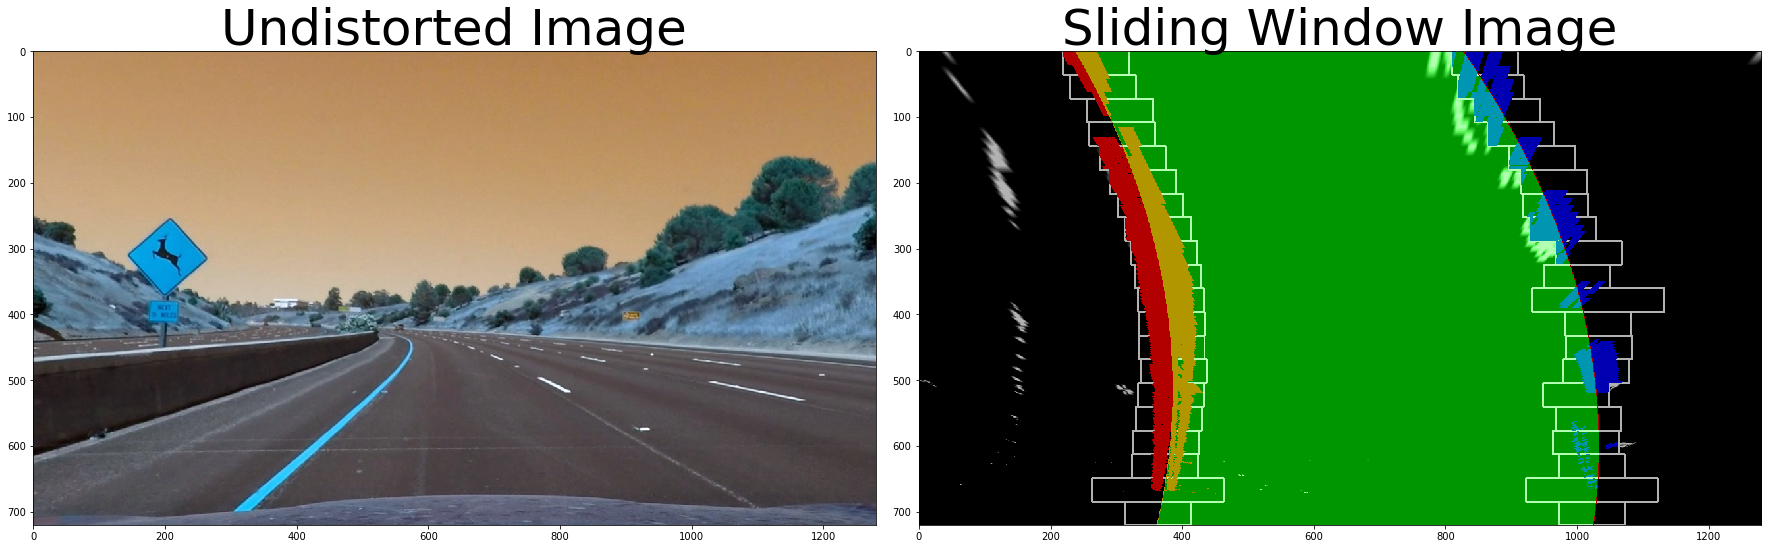

In [7]:
left_fit_past = []
right_fit_past = []
left_fit_cr_past = []
right_fit_cr_past = []
leftx_past_window_array = []
rightx_past_window_array = []
left_past_curverad = 0
right_past_curverad = 0
lost_frames = 0
original_coordinates = []
warped_coordinates = []

img = cv2.imread('test_images/test2.jpg')
undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
binary_img = binary_threshold(undistorted_img, sobel_kernel_size = 7, sx_thresh=(20, 100))
warped_img = birdseye_transform(binary_img)
sliding_window_img, curve_rad, offset = apply_sliding_window(warped_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_img)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(sliding_window_img)
ax2.set_title('Sliding Window Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('Binary_Thresholded_Image.png')
plt.show()
plt.close(f)    # close the figure

## Unwarp image to original view

In [11]:
def unwarp_image(img):
    global M_inv
    
    ysize = img.shape[0]
    xsize = img.shape[1]

    M_inv = cv2.getPerspectiveTransform(warped_coordinates,original_coordinates)
    unwarped = cv2.warpPerspective(img, M_inv, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR) 
    
    return unwarped

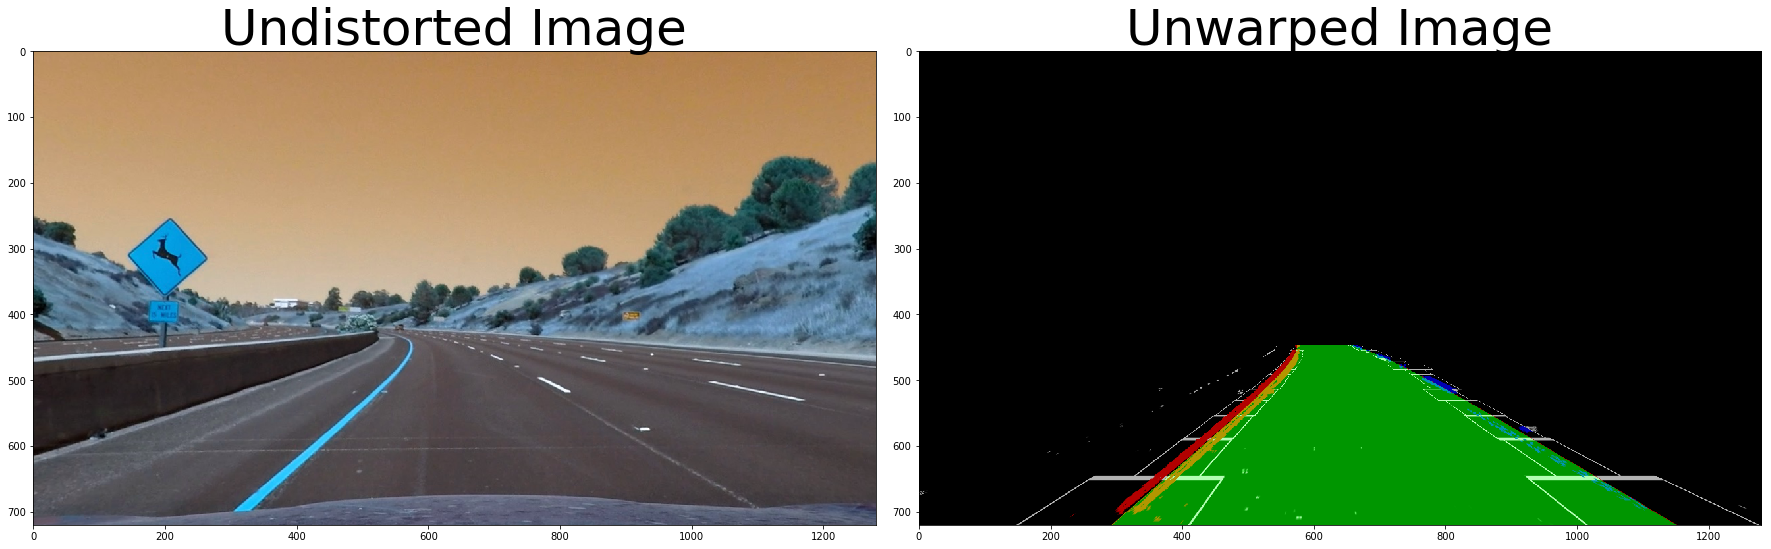

In [9]:
img = cv2.imread('test_images/test2.jpg')
undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
binary_img = binary_threshold(undistorted_img, sobel_kernel_size = 7, sx_thresh=(20, 100))
warped_img = birdseye_transform(binary_img)
sliding_window_img, curve_rad, offset = apply_sliding_window(warped_img)
unwarped_img = unwarp_image(sliding_window_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_img)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(unwarped_img)
ax2.set_title('Unwarped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('Binary_Thresholded_Image.png')
plt.show()
plt.close(f)    # close the figure

## Post process the image and add text for curvature and offset

In [12]:
def post_process_image(img, curve_rad, offset):

    post_process_img = np.copy(img)  
    cv2.putText(post_process_img,'Radius of curvature: ' + str(int(curve_rad)) + '(m)',\
                (200,100), cv2.FONT_HERSHEY_SIMPLEX, 2,(0,0,0),5)
    
    if (offset > 0):
        text = 'right'
    else:
        text = 'left'
            
    cv2.putText(post_process_img,'Vehicle is ' + "{0:.2f}".format(np.absolute(offset)) + '(m) ' + text + ' of center',\
                (100,150), cv2.FONT_HERSHEY_SIMPLEX, 2,(0,0,0),5)

    return post_process_img

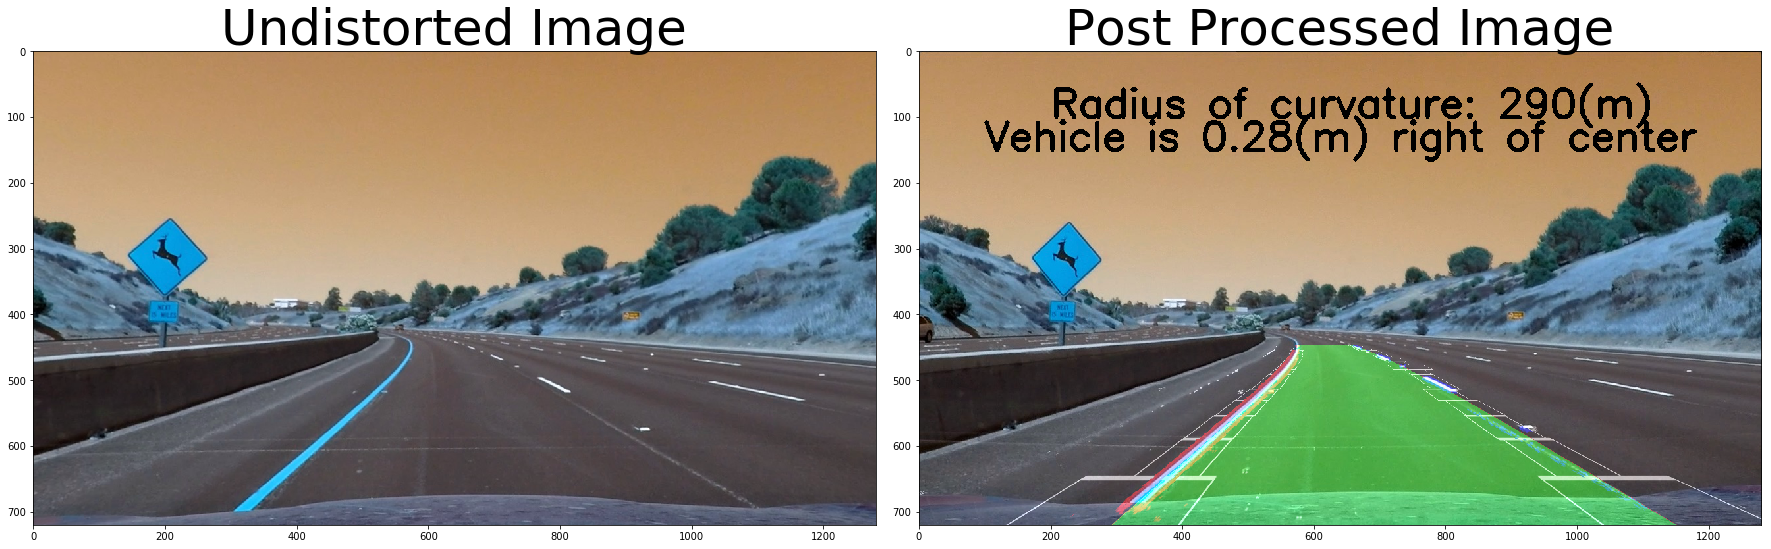

In [13]:
img = cv2.imread('test_images/test2.jpg')
undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
binary_img = binary_threshold(undistorted_img, sobel_kernel_size = 7, sx_thresh=(20, 100))
warped_img = birdseye_transform(binary_img)
sliding_window_img, curve_rad, offset = apply_sliding_window(warped_img)
unwarped_img = unwarp_image(sliding_window_img)
weighted_img = weight_image(unwarped_img, img, 1, 0.7)
post_processed_img = post_process_image(weighted_img, curve_rad, offset)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_img)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(post_processed_img)
ax2.set_title('Post Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('Binary_Thresholded_Image.png')
plt.show()
plt.close(f)    # close the figure

## Apply image processing pipeline

Create a pipeline for image processing which performs the following steps:

1. Undistort
2. Binary Threshold
3. Warp
4. Apply Sliding Window
5. Unwarp
6. Superpose lane with original image
7. Add curvature and lane-offset information


In [13]:
def pipeline(img):
    img_copy = np.copy(img)
    undistorted_img = cv2.undistort(img_copy, mtx, dist, None, mtx)
    binary_img = binary_threshold(undistorted_img, sobel_kernel_size = 7, sx_thresh=(20, 100))
    warped_img = birdseye_transform(binary_img)
    sliding_window_img, curve_rad, offset = apply_sliding_window(warped_img)
    unwarped_img = unwarp_image(sliding_window_img)
    weighted_img = weight_image(unwarped_img, img, 1, 0.7)
    post_processed_img = post_process_image(weighted_img, curve_rad, offset)
    return img, undistorted_img, binary_img, warped_img, sliding_window_img, \
           unwarped_img, weighted_img, post_processed_img

def pipeline_result(img):
    img, undistorted_img, binary_img, warped_img, \
    sliding_window_img, unwarped_img, weighted_img, \
    post_processed_img = pipeline(img)

    if (0):
        # Plot the result
        f, axr = plt.subplots(8, 1, figsize=(50, 20))
        f.tight_layout()

        axr[0].set_title('Original Image', fontsize=20)
        axr[0].imshow(img)
        
        axr[1].set_title('Undistorted Image', fontsize=20)
        axr[1].imshow(undistorted_img)

        axr[2].set_title('Binary Image', fontsize=20)
        axr[2].imshow(binary_img)

        axr[3].set_title('Warped (Birds-eye) Image', fontsize=20)
        axr[3].imshow(warped_img)

        axr[4].set_title('Sliding Window Image', fontsize=20)
        axr[4].imshow(sliding_window_img)

        axr[5].set_title('Unwarped Image', fontsize=20)
        axr[5].imshow(unwarped_img)

        axr[6].set_title('Weighted Image', fontsize=20)
        axr[6].imshow(weighted_img)

        axr[7].set_title('Pipeline Result', fontsize=20)
        axr[7].imshow(post_processed_img,cmap='gray')

        #plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

        plt.savefig('Image_Processing_Pipeline.png')
        plt.close(f)    # close the figure        
    
    return post_processed_img

img = cv2.imread('test_images/test6.jpg')
sliding_window_img = pipeline_result(img)

## Apply pipeline to movie stream

In [14]:
# Import everything needed to edit/save/watch video clips
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Edit this function to create your own pipeline.
M = []
M_inv = []
left_fit_past = []
right_fit_past = []
left_fit_cr_past = []
right_fit_cr_past = []
leftx_past_window_array = []
rightx_past_window_array = []
left_past_curverad = 0
right_past_curverad = 0
lost_frames = 0
original_coordinates = []
warped_coordinates = []

output = 'project_video_output.mp4'
#output = 'challenge_video_output_5s.mp4'
#output = 'harder_challenge_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("challenge_video.mp4").subclip(0,5)
#clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(0,5)
out_clip = clip1.fl_image(pipeline_result) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [08:43<00:00,  2.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 8min 44s
